In [1]:
# Repository setup and reproducibility
from pathlib import Path
import sys

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.


# Project 6: Random Forests — Ensembles & Aggregation

## Goal
Build random forests from scratch; understand bootstrap aggregation, variance reduction, and feature importance.

## Learning Objectives
- Understand bootstrap samples and bagging
- Implement forest training (parallel tree building)
- Visualize out-of-bag error and forest predictions
- Compare single tree vs forest generalization
- Extract feature importance from forest

## Prerequisites
- Project 5 (Decision Trees)

## What You'll Build
- NumPy random forest; OOB error curves; feature importance aggregation

## Estimated Time
- 3–5 hours

---

# Project 6: Ensemble Methods (Random Forests)

## Goal
Understand how combining models improves performance.

## Learning Objectives
- Why averaging multiple models helps
- Bootstrap sampling and bagging
- Variance reduction through ensembles
- Feature importance stability

In [2]:
# Setup
import sys
from pathlib import Path

# Dynamically add the repository root to sys.path (no hard-coded user paths)
def add_repo_root_to_syspath(marker_files=("requirements.txt", "README.md", ".git")):
    p = Path.cwd().resolve()
    while True:
        if any((p / m).exists() for m in marker_files):
            if str(p) not in sys.path:
                sys.path.insert(0, str(p))
            return p
        if p.parent == p:
            # Reached filesystem root without finding a marker
            return None
        p = p.parent

REPO_ROOT = add_repo_root_to_syspath()
print(f"Repo root detected: {REPO_ROOT}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


Repo root detected: /Users/markcastillo/git/learning-ml-to-llm/projects/phase1_classical_ml


## Step 1: Generate Complex Classification Data

We'll create a challenging dataset to demonstrate the power of ensembles.

In [3]:
# Create a complex dataset with informative and noisy features
np.random.seed(42)

X, y = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    flip_y=0.1,  # Add 10% label noise
    random_state=42
)

# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution: {np.bincount(y_train)}")

Training samples: 350
Test samples: 150
Number of features: 20
Class distribution: [164 186]


## Step 2: Demonstrate Bootstrap Sampling

Bootstrap sampling is the foundation of bagging (Bootstrap AGGregatING).

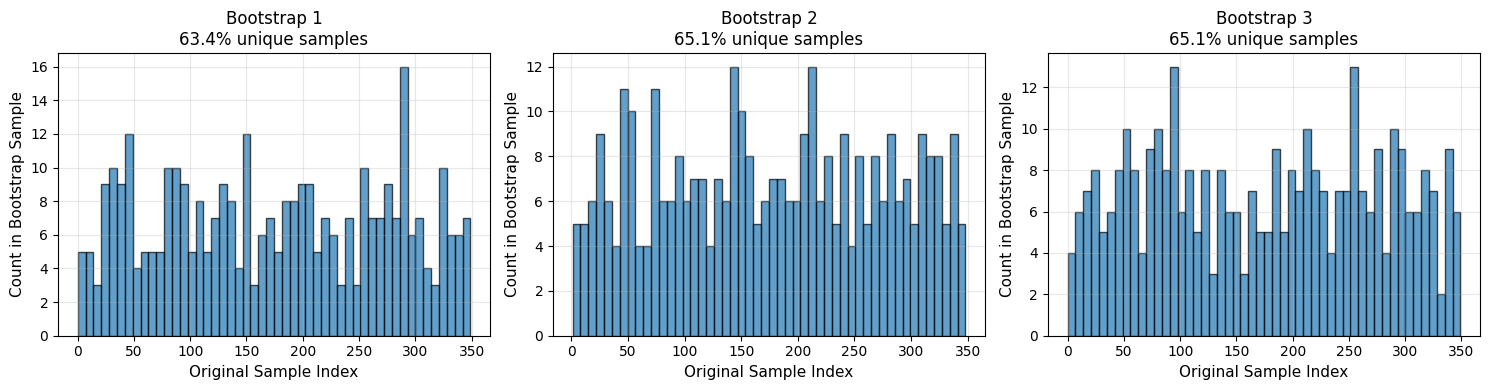

Bootstrap Sampling Insights:
• Each bootstrap sample has SAME size as original dataset
• Sampling WITH REPLACEMENT → some samples appear multiple times
• On average, ~63.2% of unique samples appear in each bootstrap
• The remaining ~36.8% are 'out-of-bag' (OOB) samples
• OOB samples can be used for validation without separate test set


In [4]:
# Demonstrate bootstrap sampling
def bootstrap_sample(X, y, random_state=None):
    """Create a bootstrap sample by sampling with replacement"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(X)
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[indices], y[indices], indices

# Create 3 bootstrap samples
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

original_indices = set(range(len(X_train)))

for i in range(3):
    X_boot, y_boot, boot_indices = bootstrap_sample(X_train, y_train, random_state=i)
    
    # Calculate what percentage of original samples are in this bootstrap
    unique_indices = set(boot_indices)
    in_sample_pct = len(unique_indices) / len(original_indices) * 100
    
    ax = axes[i]
    ax.hist(boot_indices, bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Original Sample Index', fontsize=11)
    ax.set_ylabel('Count in Bootstrap Sample', fontsize=11)
    ax.set_title(f'Bootstrap {i+1}\n{in_sample_pct:.1f}% unique samples', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Bootstrap Sampling Insights:")
print("=" * 70)
print("• Each bootstrap sample has SAME size as original dataset")
print("• Sampling WITH REPLACEMENT → some samples appear multiple times")
print("• On average, ~63.2% of unique samples appear in each bootstrap")
print("• The remaining ~36.8% are 'out-of-bag' (OOB) samples")
print("• OOB samples can be used for validation without separate test set")
print("=" * 70)

## Step 3: Compare Single Tree vs Random Forest

Let's see how ensembles improve performance over a single decision tree.

In [5]:
# Compare single tree vs ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Single deep tree (prone to overfitting)
single_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
single_tree.fit(X_train, y_train)

# Random Forest with 100 trees
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Evaluate both
models = {
    'Single Tree': single_tree,
    'Random Forest (100 trees)': rf
}

results = []
for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Overfit Gap': train_acc - test_acc
    })

import pandas as pd
results_df = pd.DataFrame(results)
print("Model Comparison:")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)
print(f"\nImprovement: {(results[1]['Test Accuracy'] - results[0]['Test Accuracy']) * 100:.2f}% better test accuracy")
print(f"Reduced overfitting: {(results[0]['Overfit Gap'] - results[1]['Overfit Gap']) * 100:.2f}% smaller gap")

Model Comparison:
                    Model  Train Accuracy  Test Accuracy  Overfit Gap
              Single Tree             1.0       0.726667     0.273333
Random Forest (100 trees)             1.0       0.820000     0.180000

Improvement: 9.33% better test accuracy
Reduced overfitting: 9.33% smaller gap


## Step 4: Visualize Variance Reduction

Show how averaging multiple models reduces prediction variance.

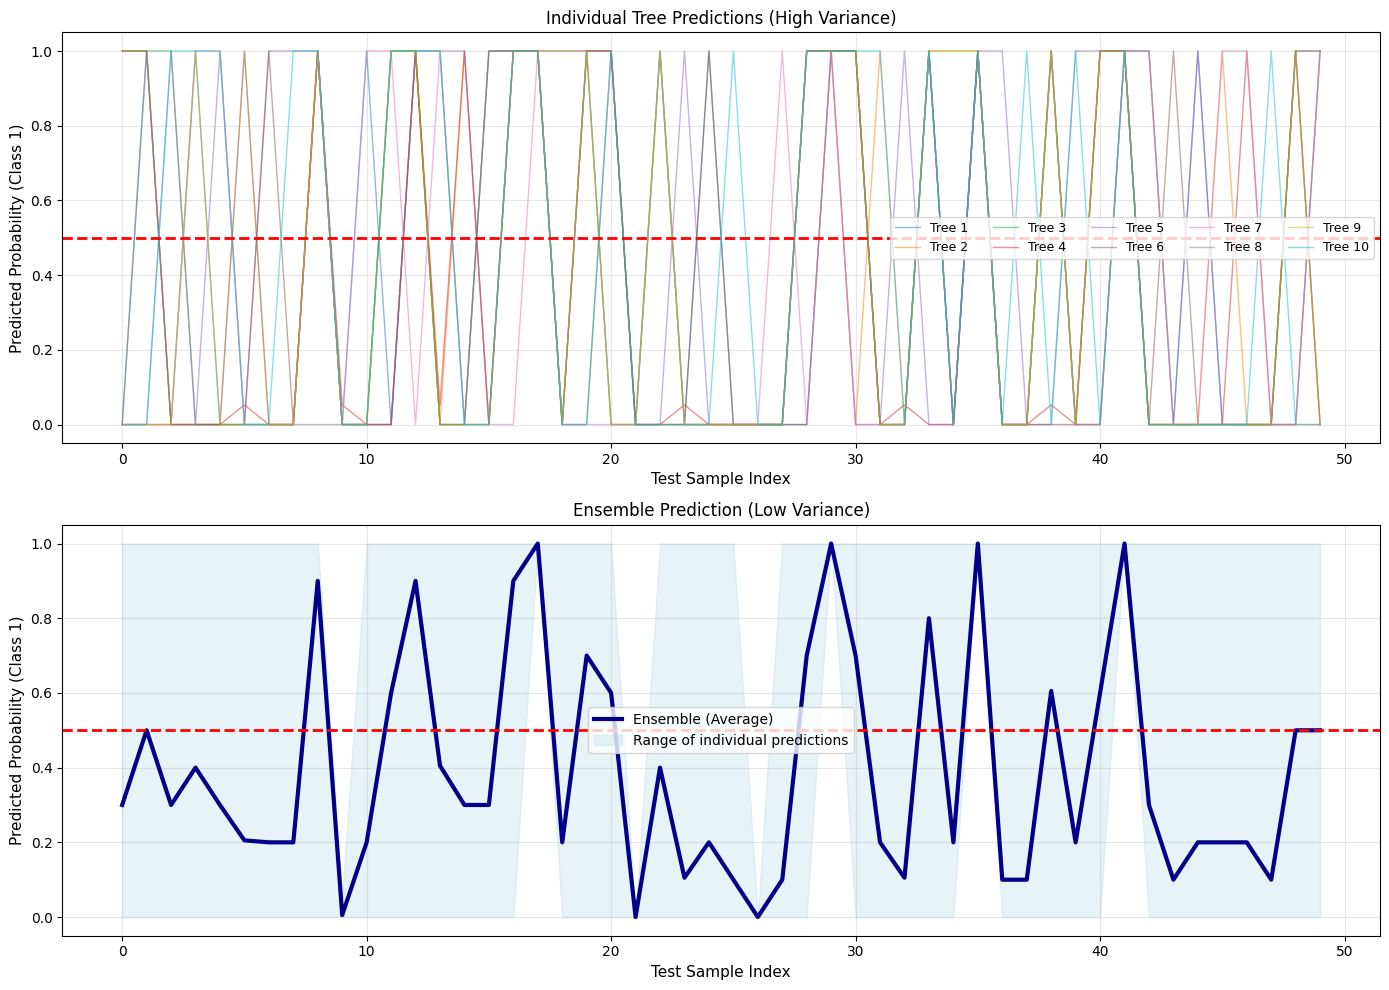


Average prediction variance:
  Individual trees: 0.1565
  Ensemble: 0.0911
  Variance reduction: 41.8%


In [6]:
# Train multiple individual trees and see their predictions vary
from sklearn.tree import DecisionTreeClassifier

n_trees = 10
individual_predictions = []

for i in range(n_trees):
    # Train on different bootstrap samples
    X_boot, y_boot, _ = bootstrap_sample(X_train, y_train, random_state=i)
    tree = DecisionTreeClassifier(max_depth=10, random_state=i)
    tree.fit(X_boot, y_boot)
    pred = tree.predict_proba(X_test)[:, 1]  # Probability of class 1
    individual_predictions.append(pred)

individual_predictions = np.array(individual_predictions)

# Calculate ensemble prediction (average)
ensemble_pred = individual_predictions.mean(axis=0)

# Visualize predictions for first 50 test samples
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot individual tree predictions
ax1 = axes[0]
for i in range(n_trees):
    ax1.plot(individual_predictions[i, :50], alpha=0.5, linewidth=1, label=f'Tree {i+1}')
ax1.set_xlabel('Test Sample Index', fontsize=11)
ax1.set_ylabel('Predicted Probability (Class 1)', fontsize=11)
ax1.set_title('Individual Tree Predictions (High Variance)', fontsize=12)
ax1.legend(ncol=5, fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')

# Plot ensemble prediction
ax2 = axes[1]
ax2.plot(ensemble_pred[:50], color='darkblue', linewidth=3, label='Ensemble (Average)')
ax2.fill_between(range(50), 
                  individual_predictions[:, :50].min(axis=0),
                  individual_predictions[:, :50].max(axis=0),
                  alpha=0.3, color='lightblue', label='Range of individual predictions')
ax2.set_xlabel('Test Sample Index', fontsize=11)
ax2.set_ylabel('Predicted Probability (Class 1)', fontsize=11)
ax2.set_title('Ensemble Prediction (Low Variance)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

# Calculate variance reduction
individual_variance = individual_predictions.var(axis=0).mean()
print(f"\nAverage prediction variance:")
print(f"  Individual trees: {individual_variance:.4f}")
print(f"  Ensemble: {ensemble_pred.var():.4f}")
print(f"  Variance reduction: {(1 - ensemble_pred.var() / individual_variance) * 100:.1f}%")

## Step 5: Impact of Number of Trees

How many trees do we need? Let's find the sweet spot.

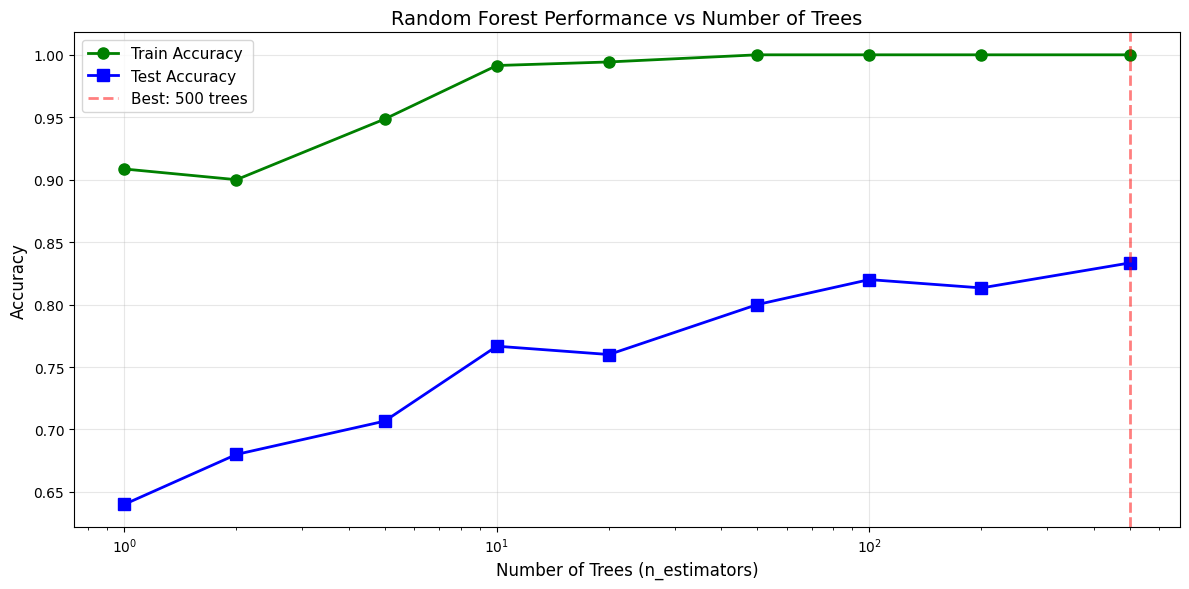

Number of Trees Analysis:
Best test accuracy: 0.8333 with 500 trees
Accuracy with 10 trees: 0.7667
Accuracy with 100 trees: 0.8200
Accuracy with 500 trees: 0.8333

Key Insight: Performance plateaus after ~50-100 trees
More trees = longer training time with minimal accuracy gain


In [7]:
# Test different numbers of trees
from sklearn.metrics import accuracy_score

n_estimators_list = [1, 2, 5, 10, 20, 50, 100, 200, 500]
train_scores = []
test_scores = []

for n_est in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    
    train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(n_estimators_list, train_scores, 'o-', linewidth=2, markersize=8, 
        label='Train Accuracy', color='green')
ax.plot(n_estimators_list, test_scores, 's-', linewidth=2, markersize=8, 
        label='Test Accuracy', color='blue')

ax.set_xlabel('Number of Trees (n_estimators)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Random Forest Performance vs Number of Trees', fontsize=14)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Mark the point of diminishing returns
best_idx = np.argmax(test_scores)
ax.axvline(x=n_estimators_list[best_idx], color='red', linestyle='--', 
           linewidth=2, alpha=0.5, label=f'Best: {n_estimators_list[best_idx]} trees')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("Number of Trees Analysis:")
print("=" * 70)
print(f"Best test accuracy: {max(test_scores):.4f} with {n_estimators_list[best_idx]} trees")
print(f"Accuracy with 10 trees: {test_scores[3]:.4f}")
print(f"Accuracy with 100 trees: {test_scores[6]:.4f}")
print(f"Accuracy with 500 trees: {test_scores[8]:.4f}")
print("\nKey Insight: Performance plateaus after ~50-100 trees")
print("More trees = longer training time with minimal accuracy gain")
print("=" * 70)

## Step 6: Feature Importance Stability

Random Forests provide more stable feature importance estimates than single trees.

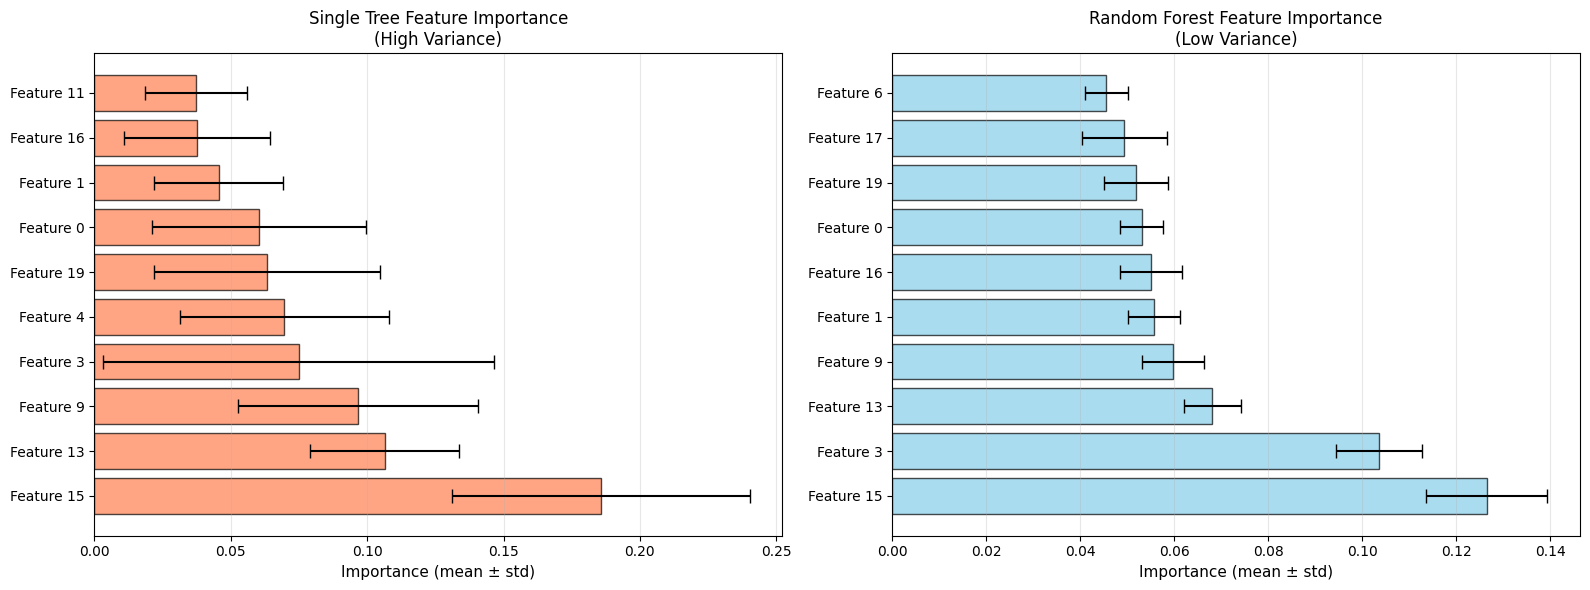

Feature Importance Stability:
Single Tree - Avg std of importance: 0.0292
Random Forest - Avg std of importance: 0.0054
Stability improvement: 81.4%

Random Forests provide more RELIABLE feature rankings!


In [8]:
# Compare feature importance stability
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

n_trials = 20
single_tree_importances = []
rf_importances = []

for i in range(n_trials):
    # Different train/test split each time
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=i)
    
    # Single tree
    tree = DecisionTreeClassifier(max_depth=10, random_state=42)
    tree.fit(X_tr, y_tr)
    single_tree_importances.append(tree.feature_importances_)
    
    # Random forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_tr, y_tr)
    rf_importances.append(rf.feature_importances_)

single_tree_importances = np.array(single_tree_importances)
rf_importances = np.array(rf_importances)

# Visualize top 10 features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Single Tree
ax1 = axes[0]
mean_imp_tree = single_tree_importances.mean(axis=0)
std_imp_tree = single_tree_importances.std(axis=0)
top_features = np.argsort(mean_imp_tree)[-10:][::-1]

ax1.barh(range(10), mean_imp_tree[top_features], xerr=std_imp_tree[top_features], 
         alpha=0.7, color='coral', edgecolor='black', capsize=5)
ax1.set_yticks(range(10))
ax1.set_yticklabels([f'Feature {i}' for i in top_features])
ax1.set_xlabel('Importance (mean ± std)', fontsize=11)
ax1.set_title('Single Tree Feature Importance\n(High Variance)', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

# Random Forest
ax2 = axes[1]
mean_imp_rf = rf_importances.mean(axis=0)
std_imp_rf = rf_importances.std(axis=0)
top_features_rf = np.argsort(mean_imp_rf)[-10:][::-1]

ax2.barh(range(10), mean_imp_rf[top_features_rf], xerr=std_imp_rf[top_features_rf], 
         alpha=0.7, color='skyblue', edgecolor='black', capsize=5)
ax2.set_yticks(range(10))
ax2.set_yticklabels([f'Feature {i}' for i in top_features_rf])
ax2.set_xlabel('Importance (mean ± std)', fontsize=11)
ax2.set_title('Random Forest Feature Importance\n(Low Variance)', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Feature Importance Stability:")
print("=" * 70)
print(f"Single Tree - Avg std of importance: {std_imp_tree.mean():.4f}")
print(f"Random Forest - Avg std of importance: {std_imp_rf.mean():.4f}")
print(f"Stability improvement: {(1 - std_imp_rf.mean() / std_imp_tree.mean()) * 100:.1f}%")
print("\nRandom Forests provide more RELIABLE feature rankings!")
print("=" * 70)

## Step 7: Out-of-Bag (OOB) Score

Random Forests can estimate test performance without a separate validation set!

Out-of-Bag (OOB) Evaluation:
OOB Score (internal validation): 0.8143
Test Score (actual held-out data): 0.8200
Difference: 0.0057

OOB Score Explanation:
• Each tree is trained on ~63% of data (bootstrap sample)
• Remaining ~37% are 'out-of-bag' samples for that tree
• For each sample, we average predictions from trees that DIDN'T see it
• This gives unbiased estimate of generalization error
• No need for separate validation set!


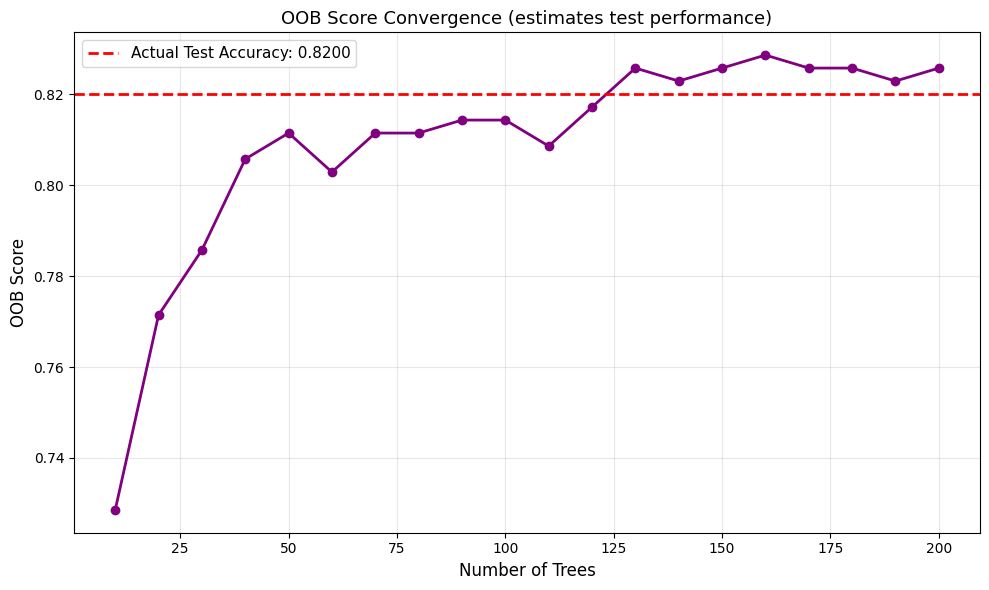

In [9]:
# Use Out-of-Bag samples for validation
from sklearn.metrics import accuracy_score

rf_with_oob = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    oob_score=True,  # Enable OOB scoring
    random_state=42
)
rf_with_oob.fit(X_train, y_train)

# Compare OOB score with actual test score
oob_accuracy = rf_with_oob.oob_score_
test_accuracy = accuracy_score(y_test, rf_with_oob.predict(X_test))

print("Out-of-Bag (OOB) Evaluation:")
print("=" * 70)
print(f"OOB Score (internal validation): {oob_accuracy:.4f}")
print(f"Test Score (actual held-out data): {test_accuracy:.4f}")
print(f"Difference: {abs(oob_accuracy - test_accuracy):.4f}")
print("\nOOB Score Explanation:")
print("• Each tree is trained on ~63% of data (bootstrap sample)")
print("• Remaining ~37% are 'out-of-bag' samples for that tree")
print("• For each sample, we average predictions from trees that DIDN'T see it")
print("• This gives unbiased estimate of generalization error")
print("• No need for separate validation set!")
print("=" * 70)

# Visualize OOB convergence
rf_convergence = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    oob_score=True,
    warm_start=True,  # Allow incremental fitting
    random_state=42
)

oob_scores = []
for n_trees in range(10, 201, 10):
    rf_convergence.n_estimators = n_trees
    rf_convergence.fit(X_train, y_train)
    oob_scores.append(rf_convergence.oob_score_)

plt.figure(figsize=(10, 6))
plt.plot(range(10, 201, 10), oob_scores, 'o-', linewidth=2, markersize=6, color='purple')
plt.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, 
            label=f'Actual Test Accuracy: {test_accuracy:.4f}')
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('OOB Score', fontsize=12)
plt.title('OOB Score Convergence (estimates test performance)', fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## Step 8: Impact of max_features (Feature Randomness)

Random Forests also randomize features at each split for further decorrelation.

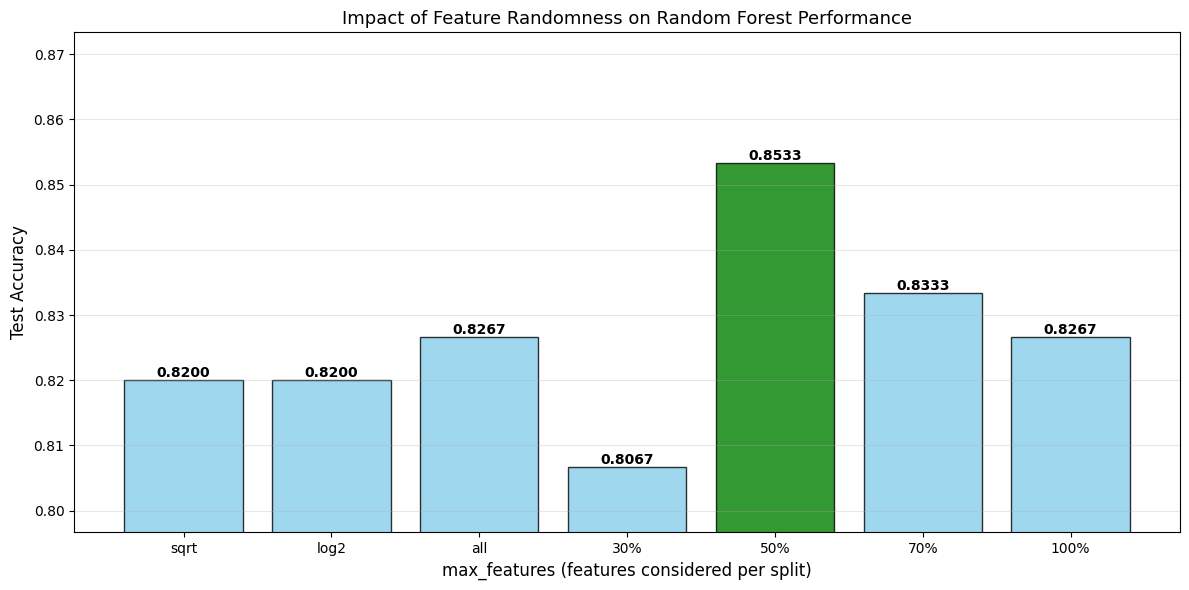

Feature Randomness Analysis:
Total features: 20
sqrt(20) = 4 features
log2(20) = 4 features

Best max_features: 50% (accuracy: 0.8533)

Key Insights:
• max_features controls randomness at each split
• Lower values → more tree diversity → lower correlation
• Default for classification: sqrt(n_features)
• Default for regression: n_features (no randomness)
• Too low → weak individual trees
• Too high → trees become correlated


In [10]:
# Test different max_features settings
from sklearn.metrics import accuracy_score

max_features_options = ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 1.0]
max_features_labels = ['sqrt', 'log2', 'all', '30%', '50%', '70%', '100%']
test_accuracies = []

for max_feat in max_features_options:
    rf = RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        max_features=max_feat,
        random_state=42
    )
    rf.fit(X_train, y_train)
    test_accuracies.append(accuracy_score(y_test, rf.predict(X_test)))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if i == np.argmax(test_accuracies) else 'skyblue' for i in range(len(test_accuracies))]
bars = ax.bar(max_features_labels, test_accuracies, color=colors, edgecolor='black', alpha=0.8)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, test_accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('max_features (features considered per split)', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Impact of Feature Randomness on Random Forest Performance', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([min(test_accuracies) - 0.01, max(test_accuracies) + 0.02])

plt.tight_layout()
plt.show()

print("Feature Randomness Analysis:")
print("=" * 70)
print(f"Total features: {X.shape[1]}")
print(f"sqrt({X.shape[1]}) = {int(np.sqrt(X.shape[1]))} features")
print(f"log2({X.shape[1]}) = {int(np.log2(X.shape[1]))} features")
print(f"\nBest max_features: {max_features_labels[np.argmax(test_accuracies)]} "
      f"(accuracy: {max(test_accuracies):.4f})")
print("\nKey Insights:")
print("• max_features controls randomness at each split")
print("• Lower values → more tree diversity → lower correlation")
print("• Default for classification: sqrt(n_features)")
print("• Default for regression: n_features (no randomness)")
print("• Too low → weak individual trees")
print("• Too high → trees become correlated")
print("=" * 70)

## Step 9: The Bias-Variance Tradeoff

Visualize how ensembles reduce variance while maintaining low bias.

/var/folders/m_/jkxbcm5n6b94gbl4hprb07280000gn/T/ipykernel_71820/2603362747.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([train_acc, test_acc], labels=['Train', 'Test'],
/var/folders/m_/jkxbcm5n6b94gbl4hprb07280000gn/T/ipykernel_71820/2603362747.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([train_acc, test_acc], labels=['Train', 'Test'],
/var/folders/m_/jkxbcm5n6b94gbl4hprb07280000gn/T/ipykernel_71820/2603362747.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([train_acc, test_acc], labels=['Train', 'Test'],


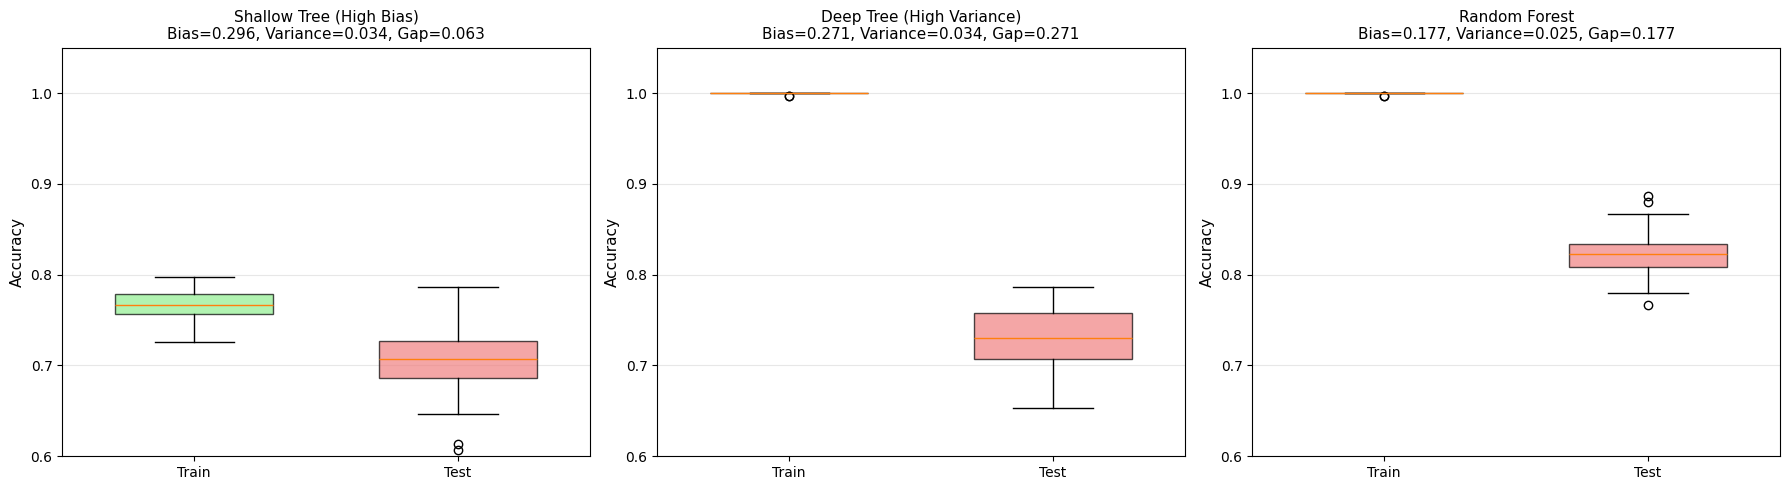


Bias-Variance Analysis:
Model                        Train Acc     Test Acc    Std(Test)          Gap
Shallow Tree (High Bias)        0.7663       0.7036       0.0336       0.0627
Deep Tree (High Variance)       0.9999       0.7288       0.0342       0.2711
Random Forest                   0.9999       0.8232       0.0246       0.1767

Key Insights:
• Shallow tree: High bias (low test accuracy), low variance (stable)
• Deep tree: Low bias (high train accuracy), high variance (unstable)
• Random Forest: Low bias AND low variance (BEST OF BOTH WORLDS)
• Gap = Train - Test accuracy (measure of overfitting)


In [11]:
# Demonstrate bias-variance tradeoff across multiple data splits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# NOTE: This cell requires X and y to be defined first (run Step 1 cell first)
n_trials = 50
models_config = [
    ('Shallow Tree (High Bias)', DecisionTreeClassifier(max_depth=2)),
    ('Deep Tree (High Variance)', DecisionTreeClassifier(max_depth=15)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10))
]

results = {name: {'train': [], 'test': []} for name, _ in models_config}

for trial in range(n_trials):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=trial)
    
    for name, model in models_config:
        # Clone and train model
        from sklearn.base import clone
        m = clone(model)
        m.fit(X_tr, y_tr)
        
        results[name]['train'].append(accuracy_score(y_tr, m.predict(X_tr)))
        results[name]['test'].append(accuracy_score(y_te, m.predict(X_te)))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, _) in enumerate(models_config):
    ax = axes[idx]
    
    train_acc = results[name]['train']
    test_acc = results[name]['test']
    
    # Box plots
    bp = ax.boxplot([train_acc, test_acc], labels=['Train', 'Test'],
                     patch_artist=True, widths=0.6)
    
    # Color boxes
    colors = ['lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add statistics
    train_mean = np.mean(train_acc)
    test_mean = np.mean(test_acc)
    train_std = np.std(train_acc)
    test_std = np.std(test_acc)
    gap = train_mean - test_mean
    
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_title(f'{name}\nBias={1-test_mean:.3f}, Variance={test_std:.3f}, Gap={gap:.3f}', 
                 fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.6, 1.05])

plt.tight_layout()
plt.show()

# Summary table
print("\nBias-Variance Analysis:")
print("=" * 90)
print(f"{'Model':<25} {'Train Acc':>12} {'Test Acc':>12} {'Std(Test)':>12} {'Gap':>12}")
print("=" * 90)
for name, _ in models_config:
    train_mean = np.mean(results[name]['train'])
    test_mean = np.mean(results[name]['test'])
    test_std = np.std(results[name]['test'])
    gap = train_mean - test_mean
    print(f"{name:<25} {train_mean:>12.4f} {test_mean:>12.4f} {test_std:>12.4f} {gap:>12.4f}")
print("=" * 90)
print("\nKey Insights:")
print("• Shallow tree: High bias (low test accuracy), low variance (stable)")
print("• Deep tree: Low bias (high train accuracy), high variance (unstable)")
print("• Random Forest: Low bias AND low variance (BEST OF BOTH WORLDS)")
print("• Gap = Train - Test accuracy (measure of overfitting)")
print("=" * 90)

## Exercises & Extensions

**Warm-up**:
1. Bootstrap sample a dataset. Count how many unique samples appear (expect ~63%).
2. Train a forest with n_trees=[1, 10, 100]. How does OOB error change?
3. Compare single tree vs forest accuracy on test set.

**Intermediate**:
4. Vary max_depth for all trees in forest. Which depth balances bias–variance?
5. Feature importance: which features dominate across all trees?
6. Analyze prediction variance: for ambiguous samples, how much do trees disagree?

**Advanced**:
7. Out-of-bag validation: use only OOB samples to estimate generalization error (no hold-out set needed).
8. Implement random subspace method (select random features per split, not just random samples).
9. Compare to sklearn’s RandomForestClassifier. Are accuracies close?

---

## Summary & Bridge Forward

**What you learned**:
- Ensemble methods combine weak learners into strong predictors.
- Bagging (bootstrap + aggregation) reduces variance without increasing bias.
- Out-of-bag error provides free validation data.
- Random forests are one of the most practical algorithms in ML.
- Feature importance from forests guides model interpretation.

**Why this matters**:
- Random forests are competitive baselines; often hard to beat without deep learning.
- Ensemble thinking (combine models) appears everywhere (modern NNs, stacking, boosting).
- OOB validation is elegant and computationally efficient.

**Next project** (Classification Metrics):
- Evaluate models properly beyond just accuracy.
- Precision, recall, ROC, F1 for imbalanced data.

**Your takeaway**: Ensembles turn weak learners into strong predictors. Averaging is powerful.